In [1]:
from __future__ import annotations

import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay
)

from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, StackingClassifier
from sklearn.inspection import permutation_importance

import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

ARTIFACTS_DIR = Path("artifacts")

In [2]:
# Вспомогательные функции для эксперимента.

# - compute_metrics: считает метрики (accuracy, F1, ROC-AUC при наличии вероятностей)
# - evaluate_on_test: единообразная оценка модели на тесте
# - save_json: аккуратное сохранение артефактов
# - plot_confusion / plot_roc: быстрая диагностика качества

def compute_metrics(y_true, y_pred, y_proba=None) -> dict:
    m = {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "f1": float(f1_score(y_true, y_pred)),
    }
    if y_proba is not None:
        try:
            m["roc_auc"] = float(roc_auc_score(y_true, y_proba))
        except Exception:
            m["roc_auc"] = None
    else:
        m["roc_auc"] = None
    return m

def evaluate_on_test(model, X_test, y_test, label: str) -> dict:
    pred = model.predict(X_test)
    proba = None
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)[:, 1]
    metrics = compute_metrics(y_test, pred, proba)
    metrics["model"] = label
    return metrics

def save_json(obj: dict, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

def plot_confusion(y_true, y_pred, title: str, file_name: str):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("pred")
    plt.ylabel("true")
    plt.xticks([0, 1])
    plt.yticks([0, 1])
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.savefig(f'artifacts/figures/{file_name}.png')
    plt.show()

def plot_roc(model, X_test, y_test, title: str, file_name: str):
    if not hasattr(model, "predict_proba"):
        print("ROC: модель не поддерживает predict_proba")
        return
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title(title)
    plt.savefig(f'artifacts/figures/{file_name}.png')
    plt.show()

In [3]:
df = pd.read_csv('S06-hw-dataset-02.csv')

display(df.head())
display(df.info(), df.describe(), df['target'].value_counts())

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f29,f30,f31,f32,f33,f34,f35,x_int_1,x_int_2,target
0,1,-0.149235,-2.826966,-0.522901,-4.198449,1.364943,0.815043,-1.195518,-1.932232,2.396353,...,-0.159323,0.448015,0.572745,0.149916,0.878392,-0.679733,1.412751,0.421883,9.217167,1
1,2,-1.966180,-4.877542,0.268367,-9.607791,0.097149,1.347185,-3.872575,-0.395117,1.710068,...,-0.389212,1.383794,0.169876,0.043969,-0.963545,1.006643,-2.488690,9.590124,24.772826,0
2,3,-0.555964,-0.999920,0.209673,-14.119498,-1.808950,-0.006222,-4.651108,0.911944,-0.289037,...,-1.383970,3.044321,-0.182864,1.425649,-8.418598,-4.629754,-0.439798,0.555919,41.800517,0
3,4,-2.049199,-5.600713,-1.664677,-6.263893,-5.224455,0.848351,1.407210,-0.542080,0.119102,...,-2.713080,2.762637,-0.520796,-0.142455,1.668338,2.292810,-10.744916,11.476977,65.315860,0
4,5,-0.220556,4.889479,-2.235840,6.450046,0.774389,-2.382625,2.584816,4.211856,-0.317889,...,-1.302872,2.478862,1.528610,1.098131,3.547087,2.517757,-9.364106,-1.078404,93.017870,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 39 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       18000 non-null  int64  
 1   f01      18000 non-null  float64
 2   f02      18000 non-null  float64
 3   f03      18000 non-null  float64
 4   f04      18000 non-null  float64
 5   f05      18000 non-null  float64
 6   f06      18000 non-null  float64
 7   f07      18000 non-null  float64
 8   f08      18000 non-null  float64
 9   f09      18000 non-null  float64
 10  f10      18000 non-null  float64
 11  f11      18000 non-null  float64
 12  f12      18000 non-null  float64
 13  f13      18000 non-null  float64
 14  f14      18000 non-null  float64
 15  f15      18000 non-null  float64
 16  f16      18000 non-null  float64
 17  f17      18000 non-null  float64
 18  f18      18000 non-null  float64
 19  f19      18000 non-null  float64
 20  f20      18000 non-null  float64
 21  f21      180

None

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f29,f30,f31,f32,f33,f34,f35,x_int_1,x_int_2,target
count,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,...,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,1.800000e+04,18000.000000
mean,9000.500000,-0.418555,0.614251,0.004559,0.059000,0.405086,0.012123,-0.283473,-0.266880,0.255107,...,-0.139825,0.108568,0.007238,0.000904,-0.716862,-0.274520,0.344991,1.517339,2.576221e+01,0.262611
std,5196.296758,2.178005,3.926778,1.000134,5.713672,2.497581,0.987226,2.193891,2.081431,2.225776,...,2.148834,2.234315,0.997861,1.002115,3.913704,2.482890,4.927315,10.630850,5.423748e+01,0.440065
min,1.000000,-10.014698,-15.510323,-4.031762,-23.663256,-12.289308,-3.741536,-9.591425,-8.293319,-13.655742,...,-8.171469,-9.214171,-3.937091,-3.963063,-19.389908,-10.031559,-20.768452,-107.788145,1.895059e-07,0.000000
25%,4500.750000,-1.866134,-2.048192,-0.673127,-3.544964,-1.153000,-0.653090,-1.743214,-1.688121,-1.177480,...,-1.589638,-1.369266,-0.663023,-0.684164,-3.286842,-1.897893,-2.752685,-2.018750,1.226029e+00,0.000000
50%,9000.500000,-0.465100,0.600291,0.003581,0.072826,0.485625,0.018765,-0.251263,-0.302463,0.350739,...,-0.204785,0.158715,0.001912,-0.003157,-0.618472,-0.339901,0.573153,0.318011,6.581865e+00,0.000000
75%,13500.250000,0.966393,3.229850,0.671390,3.689490,2.075739,0.689304,1.195481,1.109589,1.764113,...,1.254595,1.600671,0.677296,0.676558,1.948803,1.314163,3.649794,4.212111,2.576847e+01,1.000000
max,18000.000000,9.589975,15.417329,3.817025,26.815691,10.665184,3.528280,7.794627,8.892834,8.699629,...,9.290667,8.794320,4.341030,3.781380,14.065595,10.639974,20.226291,94.891804,1.103449e+03,1.000000


target
0    13273
1     4727
Name: count, dtype: int64

In [4]:
X = df.iloc[:, 1:-1] 
y = df["target"]

feature_names = list(df.columns[1:-1])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=y
)

X_train.shape, X_test.shape

((13500, 37), (4500, 37))

Фиксированный seed и стратификация важны для сохранения распределния классов и воспроизводимости эксперимента

In [6]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

results = []
best_models = {}  # label -> fitted best estimator
search_summaries = {}  # label -> краткая инфа о подборе

# Dummy baseline (без подбора)

dummy = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)
results.append(evaluate_on_test(dummy, X_test, y_test, "Dummy(most_frequent)"))
best_models["Dummy(most_frequent)"] = dummy

# 2.2 LogisticRegression baseline (с минимальным подбором)

lr = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=4000, random_state=RANDOM_STATE))
])


# Подбираем C

lr_grid = {
    "lr__C": list(range(1, 10)),
    "lr__penalty": ["l2"],
    "lr__solver": ["lbfgs"],
}


lr_search = GridSearchCV(
    lr, lr_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True,
    return_train_score=True
)
lr_search.fit(X_train, y_train)

best_lr = lr_search.best_estimator_
best_models["LogReg(scaled)"] = best_lr

search_summaries["LogReg(scaled)"] = {
    "best_params": lr_search.best_params_,
    "best_cv_roc_auc": float(lr_search.best_score_),
}

results.append(evaluate_on_test(best_lr, X_test, y_test, "LogReg(scaled)"))

In [7]:
def run_search(label: str, estimator, param_grid: dict):
    search = GridSearchCV(
        estimator,
        param_grid,
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1,
        refit=True,
        return_train_score=True
    )
    search.fit(X_train, y_train)

    best = search.best_estimator_
    best_models[label] = best
    search_summaries[label] = {
        "best_params": search.best_params_,
        "best_cv_roc_auc": float(search.best_score_),
    }
    results.append(evaluate_on_test(best, X_test, y_test, label))
    return search

In [8]:
# Decision Tree: одна модель дерева решений.

dt = DecisionTreeClassifier(random_state=RANDOM_STATE)

dt_grid = {
    "max_depth": [None, 1, 3, 5, 9, 10, 15],
    "min_samples_leaf": [1, 3, 5, 10, 15, 20, 25, 30],
    "ccp_alpha": [0.0, 0.001, 0.005, 0.01,],
}

dt_search = run_search("DecisionTree", dt, dt_grid)
search_summaries["DecisionTree"]

{'best_params': {'ccp_alpha': 0.0, 'max_depth': 10, 'min_samples_leaf': 25},
 'best_cv_roc_auc': 0.8326058943666812}

In [9]:
# Random Forest: ансамбль деревьев (bagging)

rf = RandomForestClassifier(
    n_estimators=600,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    oob_score=False
)

rf_grid = {
    "max_depth": [None, 6, 10, 20],
    "min_samples_leaf": [1, 5, 10],
    "max_features": ["sqrt", 0.5],
}

rf_search = run_search("RandomForest", rf, rf_grid)
search_summaries["RandomForest"]

{'best_params': {'max_depth': 20,
  'max_features': 'sqrt',
  'min_samples_leaf': 1},
 'best_cv_roc_auc': 0.927541780041215}

In [10]:
# HistGradientBoosting: градиентный бустинг по гистограммам

hgb = HistGradientBoostingClassifier(
    random_state=RANDOM_STATE,
    early_stopping=True
)

hgb_grid = {
    "learning_rate": [0.03, 0.05, 0.1, 0.15, 0.01],
    "max_depth": [2, 3, None, 5, 10],
    "max_leaf_nodes": [15, 31, 63, 100],
}

hgb_search = run_search("HistGradientBoosting", hgb, hgb_grid)
search_summaries["HistGradientBoosting"]

{'best_params': {'learning_rate': 0.15,
  'max_depth': None,
  'max_leaf_nodes': 63},
 'best_cv_roc_auc': 0.9302371248899313}

In [11]:
# Stacking: ансамбль из нескольких уже обученных моделей + метамодель.

estimators = [
    ("lr", best_models["LogReg(scaled)"]),
    ("dt", best_models["DecisionTree"]),
    ("rf", best_models["RandomForest"]),
    ("hgb", best_models["HistGradientBoosting"]),
]

stack = StackingClassifier(
    estimators=estimators,
    final_estimator=HistGradientBoostingClassifier(early_stopping=True,
                                                                learning_rate=0.15,
                                                                max_leaf_nodes=63,
                                                                random_state=42),
    cv=5,
    n_jobs=-1,
    passthrough=False
)

stack.fit(X_train, y_train)
best_models["Stacking"] = stack
results.append(evaluate_on_test(stack, X_test, y_test, "Stacking"))

In [12]:
# Сводка результатов в таблицу
df_res_info = pd.DataFrame(results)

df_sorted = df_res_info.copy()
df_sorted["roc_auc_sort"] = df_sorted["roc_auc"].fillna(-1.0)
df_sorted = df_sorted.sort_values(["roc_auc_sort", "accuracy"], ascending=False).drop(columns=["roc_auc_sort"])

df_sorted

,accuracy,f1,roc_auc,model
5,0.915111,0.831272,0.934230,Stacking
4,0.908444,0.810313,0.931756,HistGradientBoosting
3,0.892222,0.759305,0.930128,RandomForest
2,0.829556,0.648649,0.841916,DecisionTree
1,0.816222,0.571724,0.800894,LogReg(scaled)
0,0.737333,0.000000,0.500000,Dummy(most_frequent)


In [13]:
# Сохранение артефактов эксперимента в artifacts/

metrics_path = ARTIFACTS_DIR / "metrics_test.json"
search_path = ARTIFACTS_DIR / "search_summaries.json"

save_json({"results": df_sorted.to_dict(orient="records")}, metrics_path)
save_json(search_summaries, search_path)

In [14]:
# Выбор “лучшей” модели по таблице результатов

best_row = df_sorted.iloc[0]
best_label = best_row["model"]
best_model = best_models[best_label]

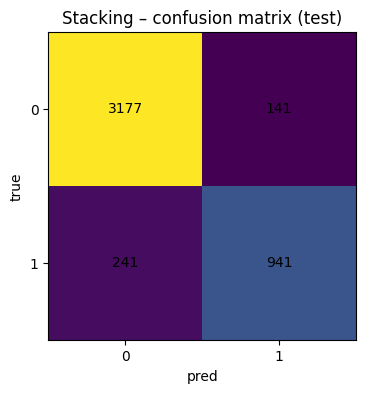

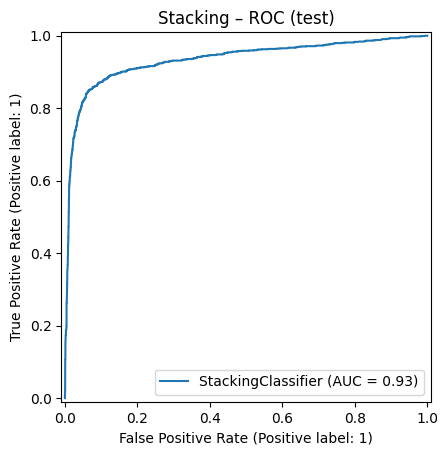

In [15]:
y_pred = best_model.predict(X_test)
plot_confusion(y_test, y_pred, title=f"{best_label} – confusion matrix (test)", file_name=f"{best_label}ConfusionMat")
plot_roc(best_model, X_test, y_test, title=f"{best_label} – ROC (test)", file_name=f"{best_label}ROC")

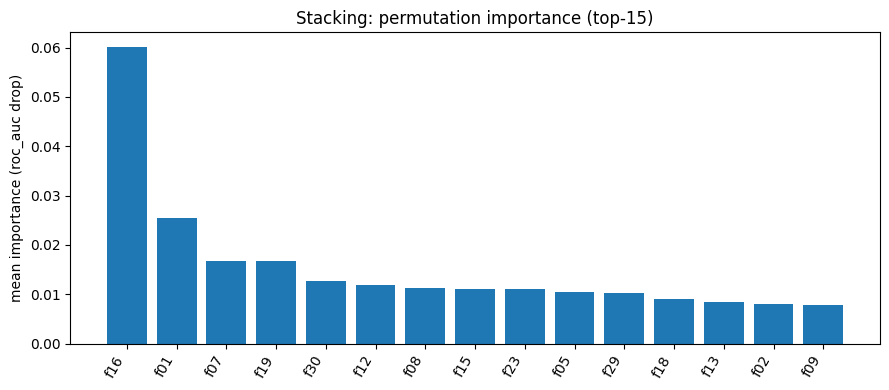

In [16]:
# Permutation importance на тесте (top-15)

scoring = "roc_auc" if hasattr(best_model, "predict_proba") else "accuracy"

perm = permutation_importance(
    best_model,
    X_test,
    y_test,
    n_repeats=8,
    random_state=RANDOM_STATE,
    scoring=scoring
)

imp = perm.importances_mean
idx = np.argsort(imp)[::-1][:15]

plt.figure(figsize=(9, 4))
plt.bar(range(len(idx)), imp[idx])
plt.xticks(range(len(idx)), [feature_names[i] for i in idx], rotation=60, ha="right")
plt.ylabel(f"mean importance ({scoring} drop)")
plt.title(f"{best_label}: permutation importance (top-15)")
plt.tight_layout()
plt.show()

In [17]:
model_path = ARTIFACTS_DIR / "best_model.joblib"
joblib.dump(best_model, model_path)

meta = {
    "best_model_label": best_label,
    "test_metrics": best_row.to_dict(),
    "search_summary": search_summaries.get(best_label, None),
    "random_state": RANDOM_STATE,
}
save_json(meta, ARTIFACTS_DIR / "best_model_meta.json")

Итого, в рамках работы, были произведены сравнения baseline’ов и моделей Decision Tree, Random Forest, HistGradientBoosting и Stacking. Последняя показала лучшие результаты среди проведенных экспериментов. Также был произведен подбор гиперпараметров. Сохранены артефакты (метрики, параметры подбора, лучшая модель и метаданные) и графики confusion matrix и ROC-кривая. Также определены самые важные влиятельные на обучение лучшей модели метрики (f16, f01, f07, f19, f30 и далее)